# Model interpretability

In [1]:
#!pip install lightgbm
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
#!pip install seaborn
#!pip install numpy==2.2
#!pip install shap 
#!pip install joblib

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import shap
import joblib

sns.set_style('whitegrid')

C:\Users\Nadiia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
SEED = 8
est = LGBMClassifier(objective='multiclass', class_weight='balanced', learning_rate=0.2, max_depth=3, n_estimators=100, num_leaves=4, verbose=-1, random_state=SEED)

final_model = est.fit(X_train, y_train.to_numpy().ravel())

In [22]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.823     0.793     0.807        82
           1      0.600     0.453     0.516        53
           2      0.357     0.455     0.400        22
           3      0.265     0.429     0.327        21
           4      0.000     0.000     0.000         6

    accuracy                          0.587       184
   macro avg      0.409     0.426     0.410       184
weighted avg      0.612     0.587     0.594       184



In [6]:
shap.initjs()

explainer = shap.Explainer(final_model)
shap_values = explainer(X_train)

shap_values.shape

(736, 25, 5)

In [7]:
# visualize one prediction's explanation
#shap.plots.waterfall(shap_values[17, :, 0])

In [8]:
# visualize one prediction's explanation with a force plot
#shap.plots.force(shap_values[17, :, 4])

In [9]:
# visualize the range of the training set predictions
# shap.plots.force(shap_values[:100, :, 4])

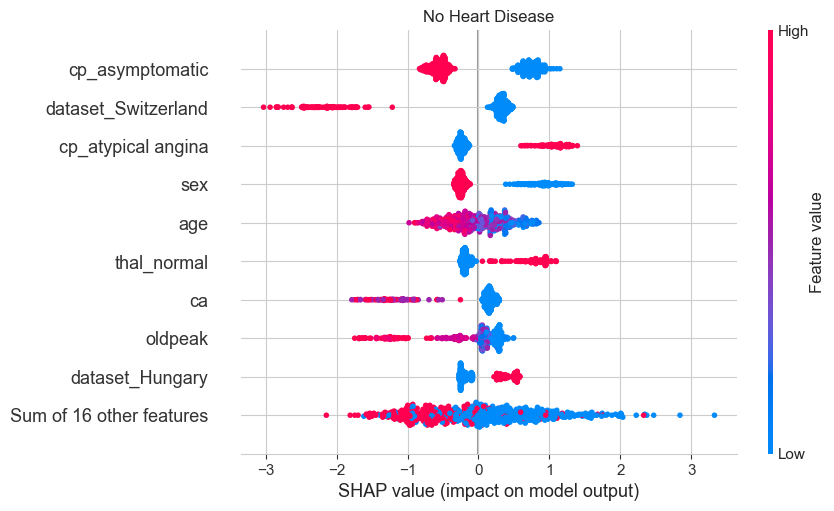

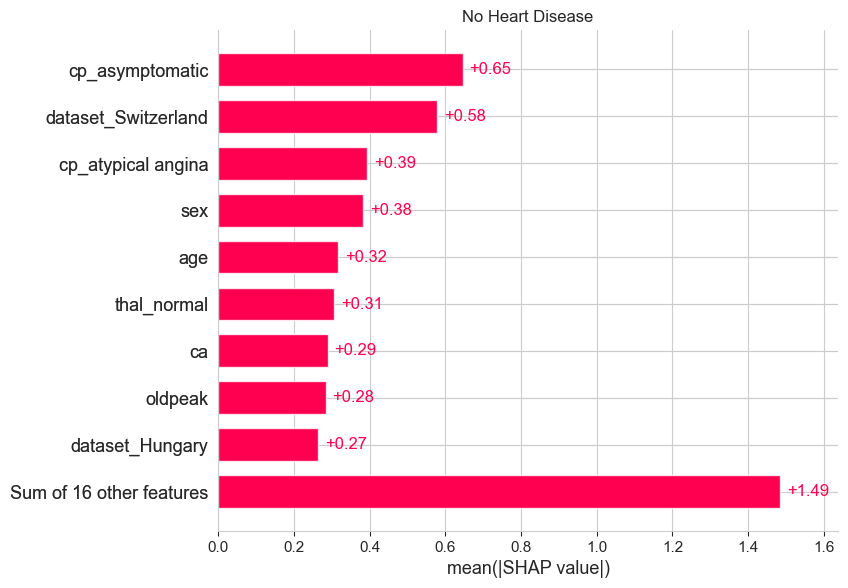

In [24]:
# summarize the effects of all the features
plt.title(f'No Heart Disease')
shap.plots.beeswarm(shap_values[:, :, 0], max_display=10)
# for example, high thal_normal shows that patient healthy, also low exang and low cp_asymptomatic
plt.title(f'No Heart Disease')
shap.plots.bar(shap_values[:, :, 0], max_display=10)

In [11]:
feature_names = X_test.columns

shap_mean_healthy = np.abs(shap_values[:, :, 0].values).mean(0)
feature_importance_healthy = [feature_names[i] for i in np.argsort(shap_mean_healthy)[::-1]]

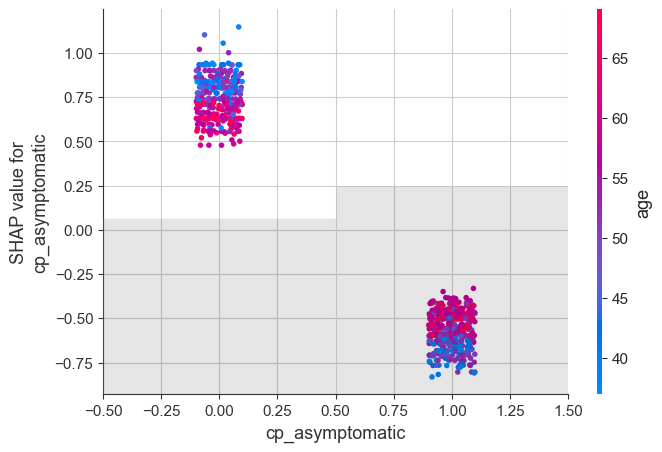

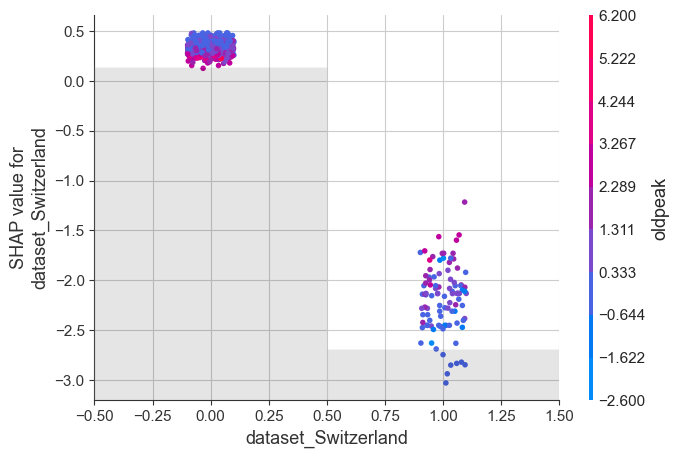

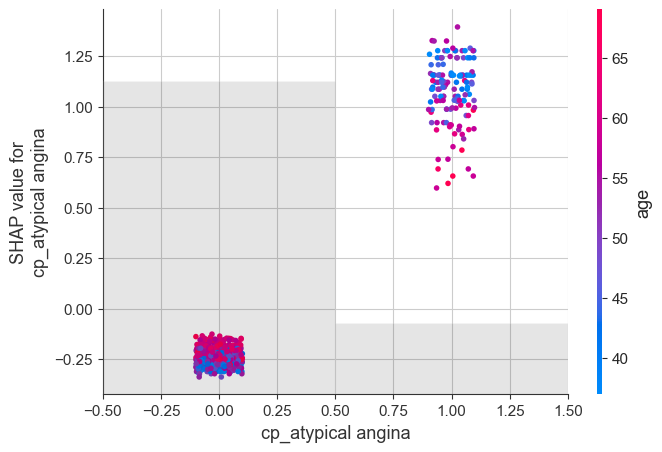

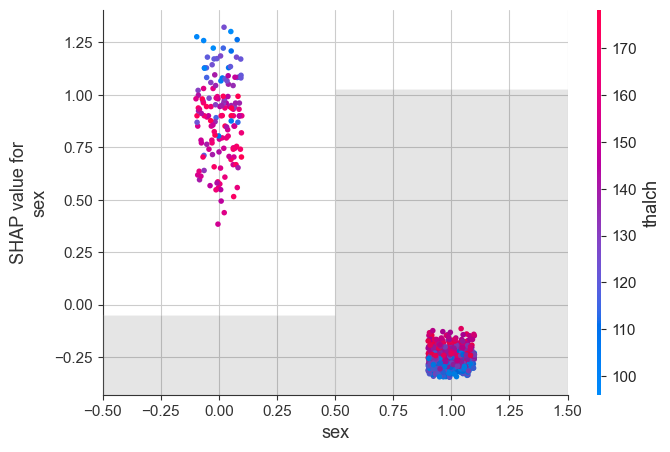

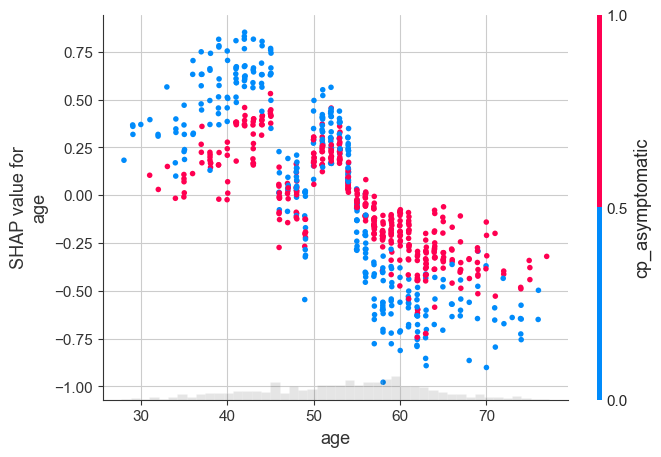

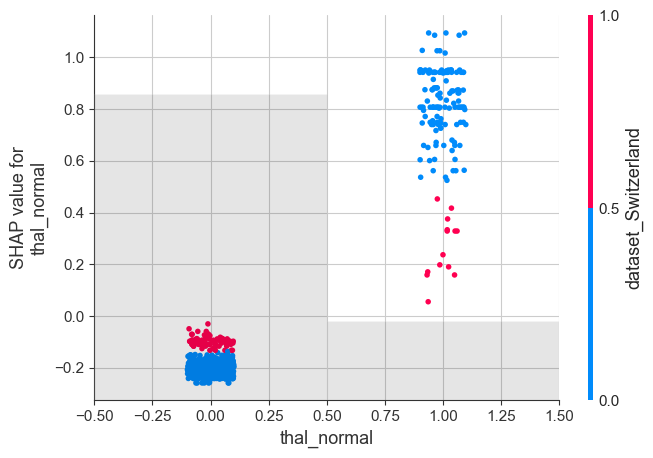

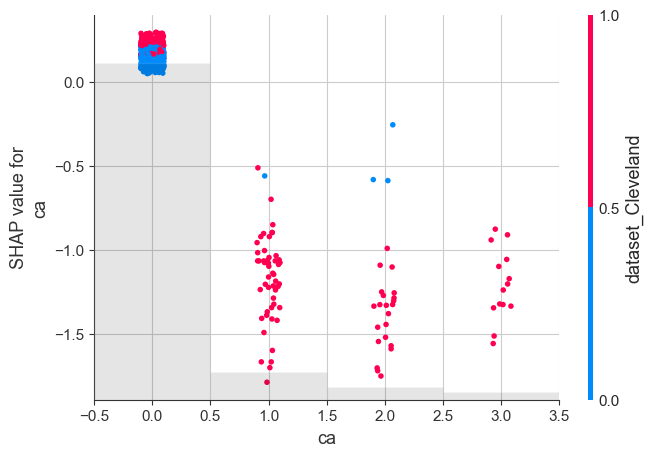

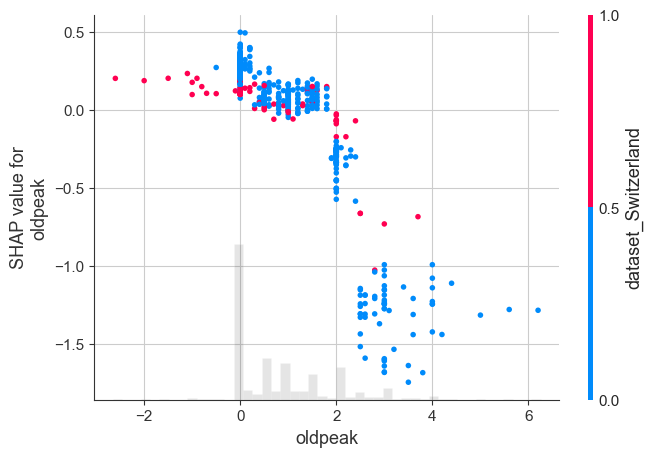

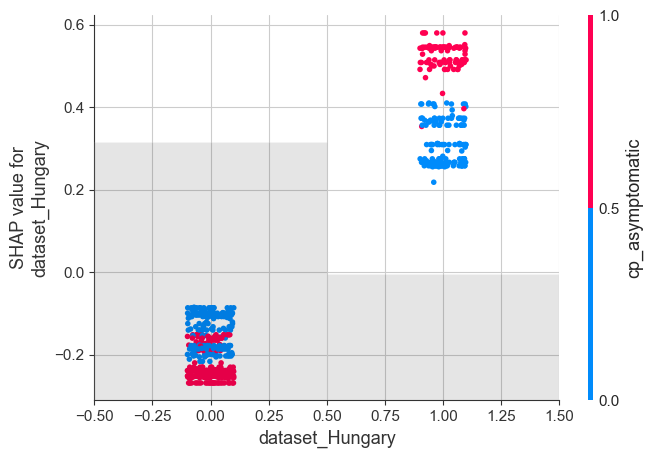

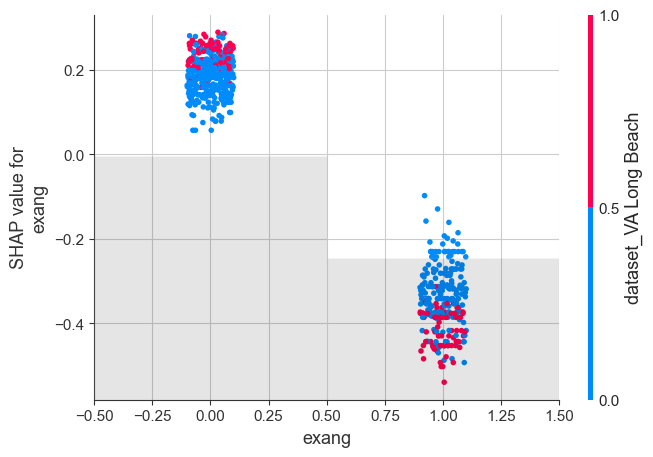

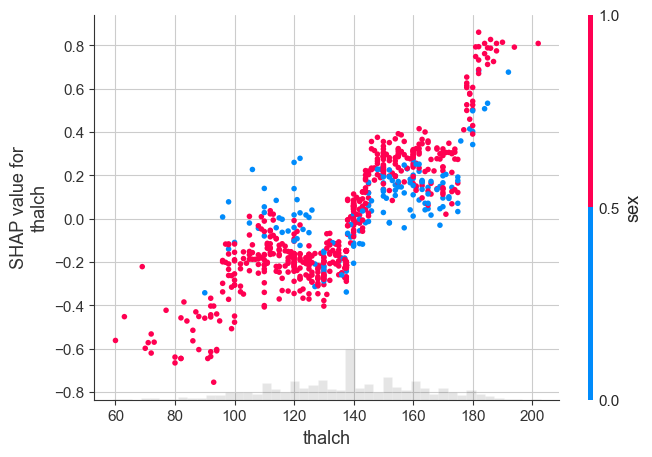

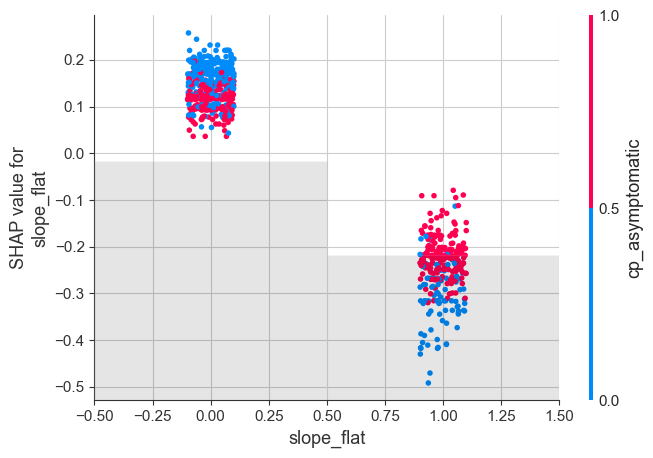

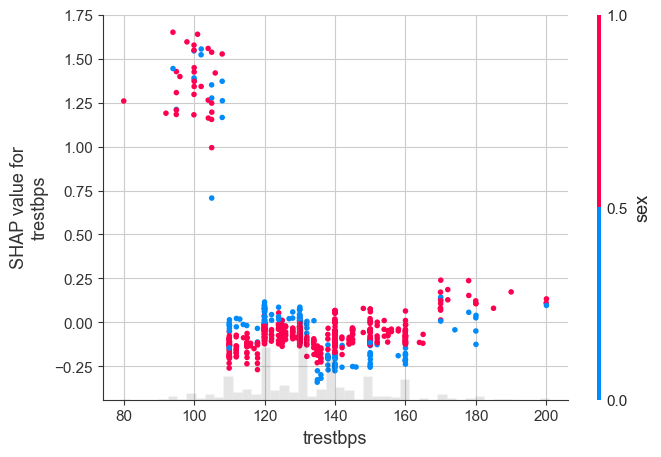

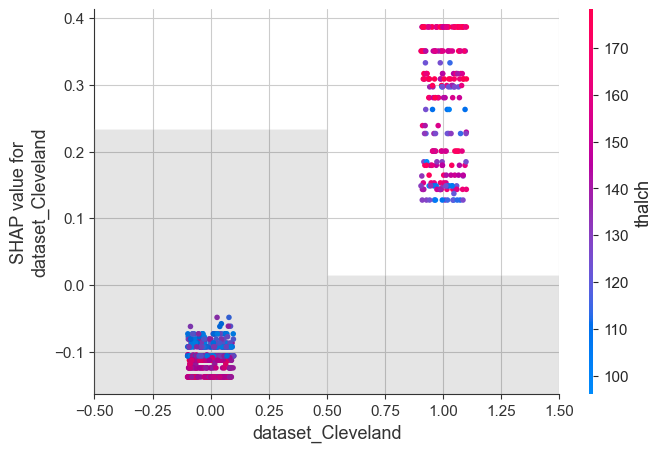

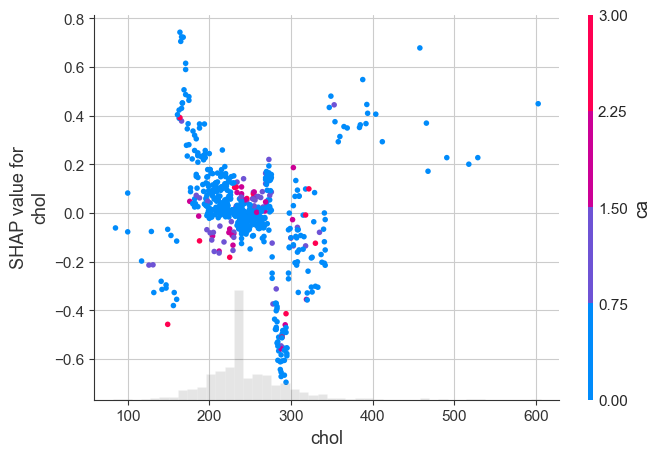

In [12]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
for feature in feature_importance_healthy[:15]:
    shap.plots.scatter(shap_values[:, feature, 0], color=shap_values[:, :, 0])

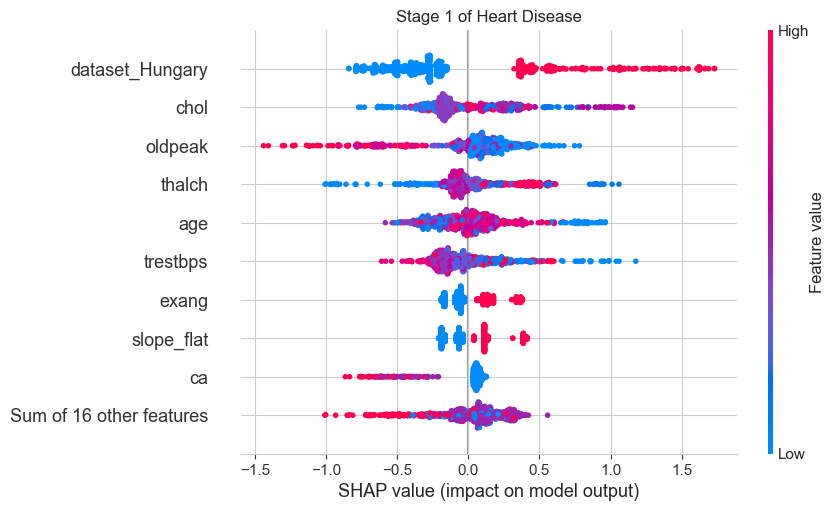

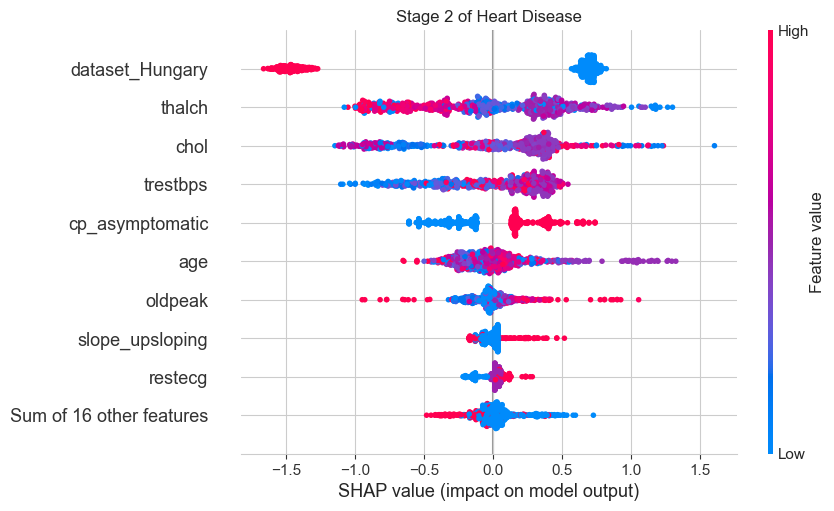

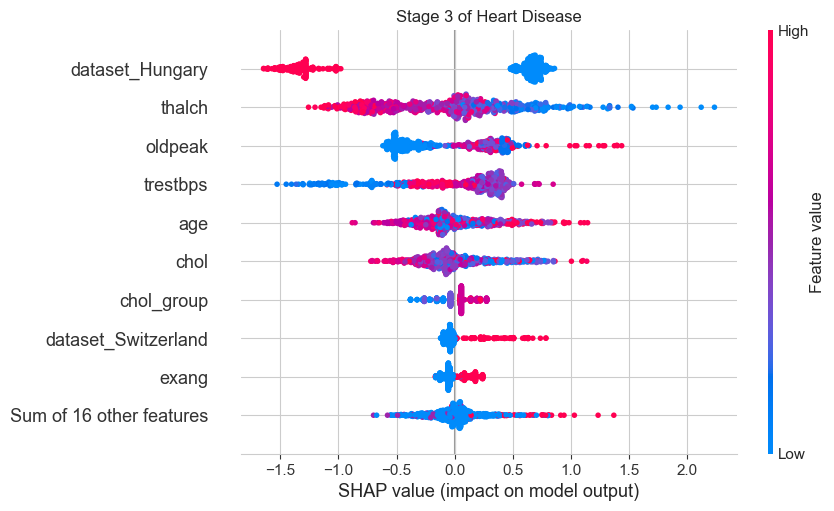

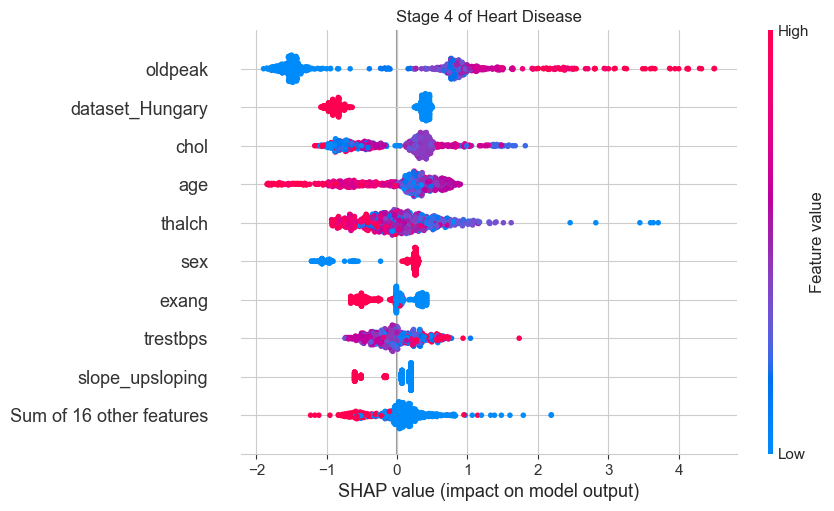

In [13]:
for i in range(4):
    plt.title(f'Stage {i+1} of Heart Disease')
    shap.plots.beeswarm(shap_values[:, :, i+1])

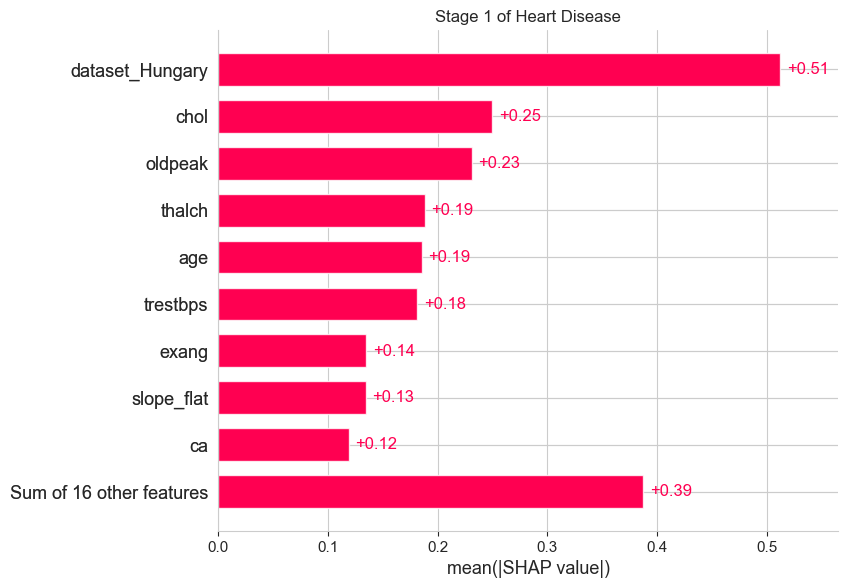

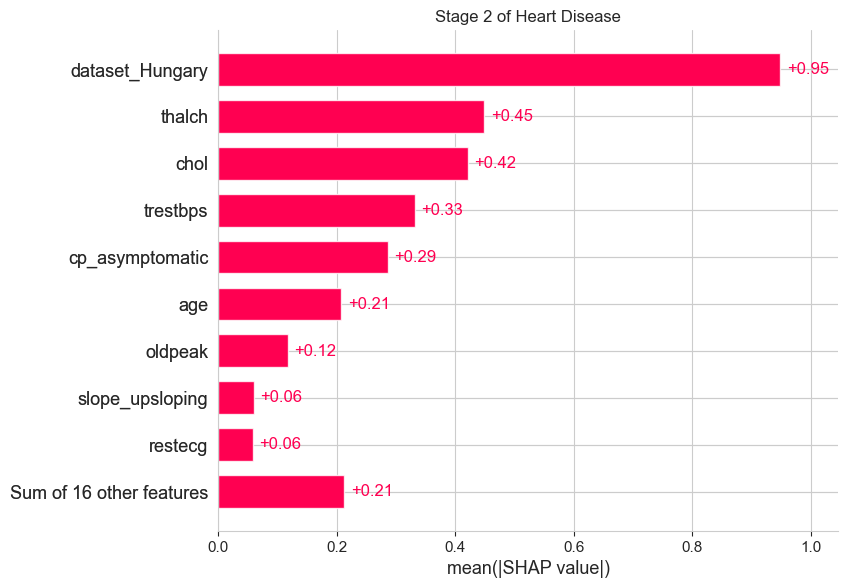

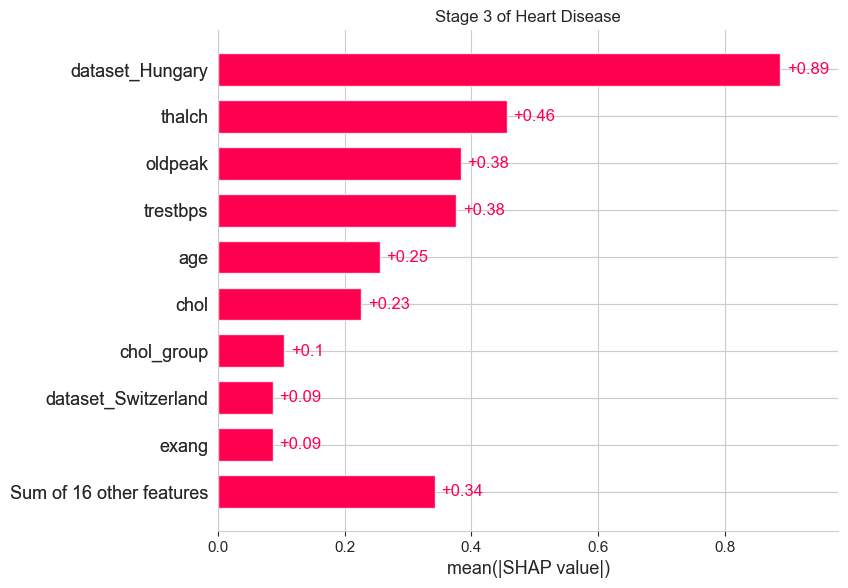

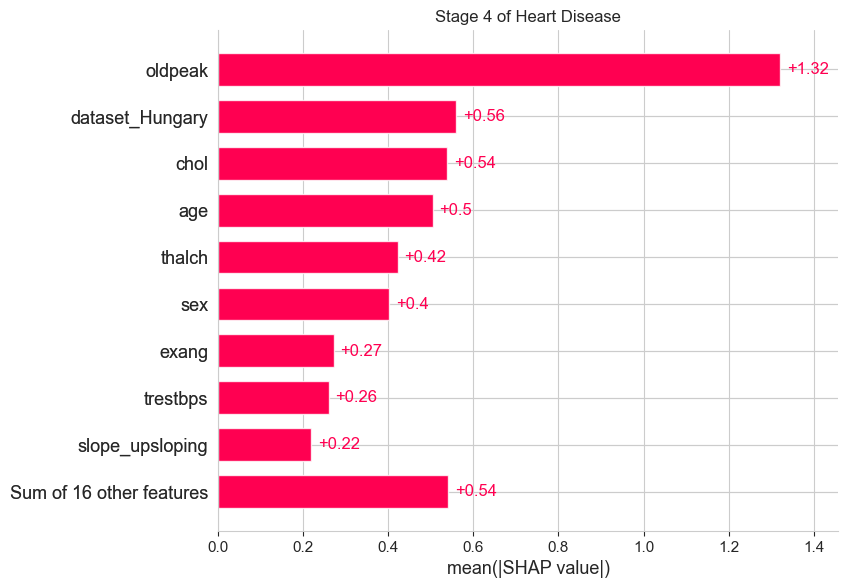

In [14]:
for i in range(4):
    plt.title(f'Stage {i+1} of Heart Disease')
    shap.plots.bar(shap_values[:, :, i+1])

In [15]:
shap_mean_ill = np.abs(shap_values[:, :, 1:].values).mean(2).mean(0)

ill_df = pd.DataFrame({'feature': feature_names, 'shap_mean': shap_mean_ill})
ill_df = ill_df.sort_values(by='shap_mean', ascending=False)
ill_df[:15]

,feature,shap_mean
12,dataset_Hungary,0.727207
8,oldpeak,0.513312
6,thalch,0.378647
3,chol,0.358950
0,age,0.288102
2,trestbps,0.287359
7,exang,0.123195
1,sex,0.115246
15,cp_asymptomatic,0.104016
21,slope_upsloping,0.081486


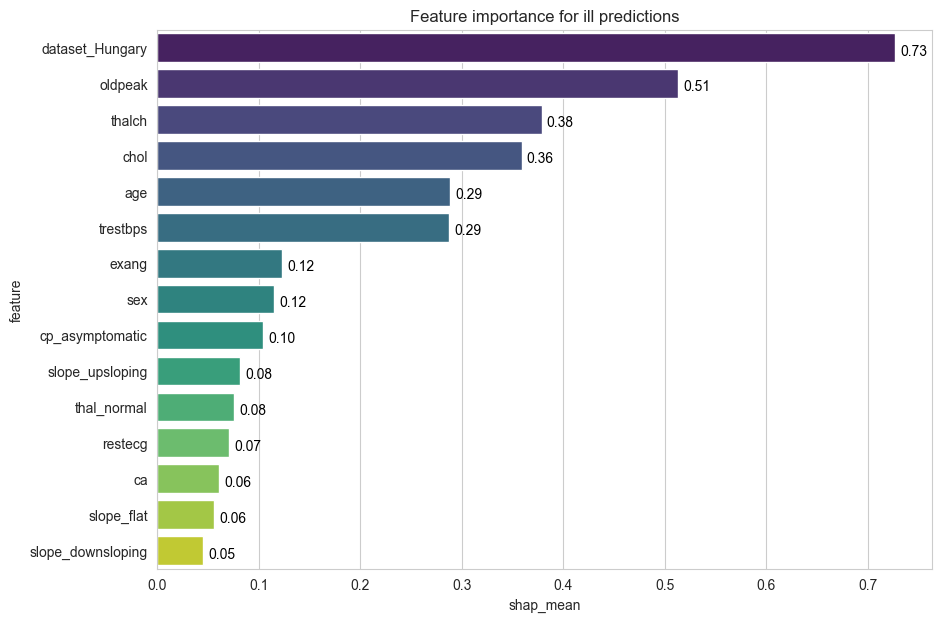

In [19]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(ill_df[:15], y='feature', x='shap_mean', hue='feature', orient='h', palette='viridis', legend=False)

# Annotate each bar
for p, shap_m in zip(ax.patches, ill_df['shap_mean']):
    width = p.get_width() + 0.005
    ax.text(width, # X-coordinate for text
            p.get_y() + p.get_height() / 2. + 0.2, # Y-coordinate for text
            f'{shap_m:.2f}',                # Text to display
            fontsize=10,
            color='black')

plt.title("Feature importance for ill predictions")
plt.savefig("ill_plot.png", dpi=300, bbox_inches="tight")

In [20]:
healthy_df = pd.DataFrame({'feature': feature_names, 'shap_mean': shap_mean_healthy})
healthy_df = healthy_df.sort_values(by='shap_mean', ascending=False)
healthy_df[:15]

,feature,shap_mean
15,cp_asymptomatic,0.646411
13,dataset_Switzerland,0.579053
16,cp_atypical angina,0.393814
1,sex,0.383489
0,age,0.317015
23,thal_normal,0.306970
9,ca,0.289195
8,oldpeak,0.284117
12,dataset_Hungary,0.265034
7,exang,0.249372


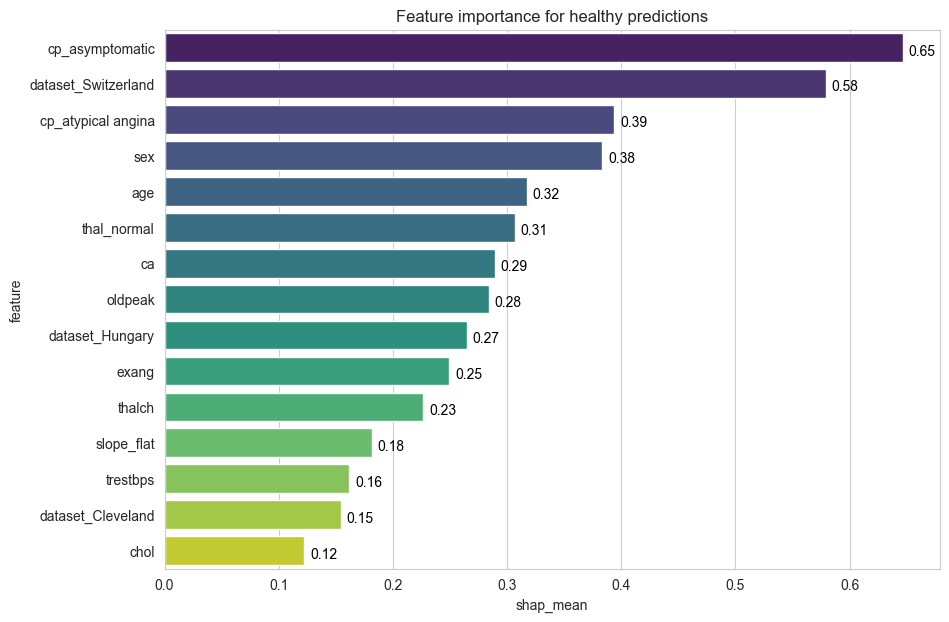

In [21]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(healthy_df[:15], y='feature', x='shap_mean', hue='feature', orient='h', palette='viridis', legend=False)

# Annotate each bar
for p, shap_m in zip(ax.patches, healthy_df['shap_mean']):
    width = p.get_width() + 0.005
    ax.text(width, # X-coordinate for text
            p.get_y() + p.get_height() / 2. + 0.2, # Y-coordinate for text
            f'{shap_m:.2f}',                # Text to display
            fontsize=10,
            color='black')

plt.title("Feature importance for healthy predictions")
plt.savefig("healthy_plot.png", dpi=300, bbox_inches="tight")